In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [36]:
orders = pd.read_csv('https://raw.githubusercontent.com/nerdmaid/Retention-analysis/main/orders.csv')


In [37]:
orders

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [38]:
orders.drop_duplicates(inplace=True)
orders['order_date'] = pd.to_datetime(orders['order_date'],infer_datetime_format=True)

In [39]:
orders['InvoiceMonth'] = orders['order_date'].dt.strftime('%Y-%m') 

In [40]:
def user_retention(df, start_period, end_period):
    def cohort_period(df):
        df['CohortPeriod'] = np.arange(len(df))
        return df
    df = df[df['InvoiceMonth'].between(start_period, end_period)]
    cohorts= df.groupby('customer_id',as_index=False)['InvoiceMonth'].min()
    cohorts.rename(columns = {'InvoiceMonth':'Cohort'},inplace=True)
    df_merged= pd.merge(df,cohorts , how='left', on='customer_id')
    cohorts_group = df_merged.groupby(['Cohort', 'InvoiceMonth']).agg({'customer_id': pd.Series.nunique})
    cohorts_group.rename(columns={'customer_id': 'TotalUsers',
                            'InvoiceNo': 'TotalOrders'}, inplace=True)
    cohorts_group = cohorts_group.groupby(level=0).apply(cohort_period)
    cohorts_group.reset_index(inplace=True)
    cohorts_group.set_index(['Cohort', 'CohortPeriod'], inplace=True) 
    cohort_group_size = cohorts_group['TotalUsers'].groupby(level=0).first()
    user_retention = cohorts_group['TotalUsers'].unstack(0).divide(cohort_group_size, axis=1)
    return user_retention.T

##### Let us check retention rate for two periods

In [74]:
retention1 = user_retention(orders, '2016-01', '2016-12')
retention2 = user_retention(orders, '2017-01', '2017-12')


In [67]:
def two_cohorts_visualization(retention_table1, retention_table2):
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    sns.heatmap(retention_table1, mask=retention_table1.isnull(), annot=True, fmt='.0%')
    plt.subplot(1, 2, 2)
    sns.heatmap(retention_table2, mask=retention_table2.isnull(), annot=True, fmt='.0%')

    
    

Here we can see retention rate of two periods, each line represents data for each cohort, each column stays for an ordinal month(first, second etc.), diagonals represent calendar monthes.

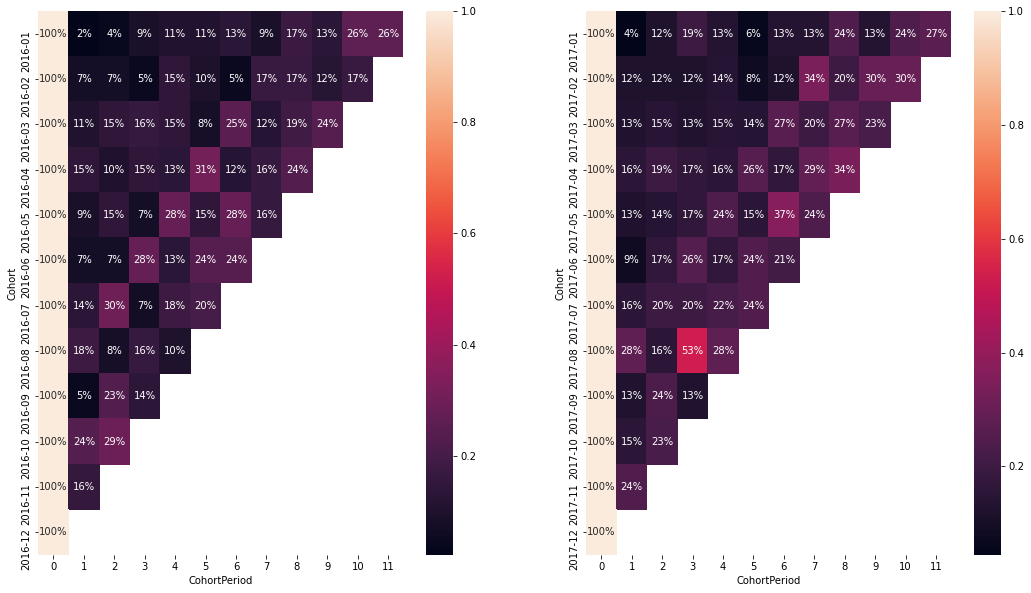

In [68]:
two_cohorts_visualization(retention1, retention2)

In [77]:
retention1.mean() - retention2.mean()

CohortPeriod
0     0.000000
1    -0.032429
2    -0.023702
3    -0.081691
4    -0.033514
5     0.001020
6    -0.033437
7    -0.099256
8    -0.069297
9    -0.056555
10   -0.053602
11   -0.007787
dtype: float64

As we can see, average retention for each month in this year(2017) is more than in previous, so our churn rate does not grow

In [87]:
retention1.mean(axis=1).reset_index(drop=True) - retention2.mean(axis=1).reset_index(drop=True)

0    -0.024037
1    -0.065277
2    -0.021347
3    -0.041592
4    -0.032519
5    -0.015117
6    -0.022643
7    -0.146000
8    -0.019170
9     0.047233
10   -0.043791
11    0.000000
dtype: float64

It is also quite similar for each cohort.

In [125]:
monthly1 = pd.DataFrame([np.diag(np.rot90(retention1), k=-i).mean() for i in range(retention1.shape[1])])
monthly2 = pd.DataFrame([np.diag(np.rot90(retention2), k=-i).mean() for i in range(retention2.shape[1])])

In [126]:
monthly1 - monthly2

,0
0,-0.043076
1,-0.071407
2,-0.050093
3,-0.016029
4,-0.051591
5,-0.002197
6,-0.007294
7,-0.021497
8,-0.043987
9,-0.040918


And for each calendar month

Summing up, we can say that our churn rate does not grow